
<a id="top"></a>

# Introduction to NARCliM2.0 Mapping - Western Australia

**Hands-on guide to plotting climate model temperature data over WA**

This notebook shows how to visualize **NARCliM2.0 tasmax** (daily maximum temperature) data:
- Subset to **Western Australia bounding box**
- Single timestep maps + multi-month faceted plots  
- Point time series extraction (e.g. near Perth)
- Professional map styling with Cartopy

**Data**: 2015 monthly tasmax, ACCESS-ESM1-5, SSP1-2.6 scenario


<a id="top"></a>
## Notebook structure

- [Imports](#Imports)
- [Load NARCliM2.0 data](#Load-NARCliM2.0-data)
- [Define WA region](#Define-WA-region)
- [Single timestep map](#Single-timestep-map)
- [Multiple timesteps](#Multiple-timesteps)
- [July 2015 WA temperature map](#July-2015-WA-temperature-map)
- [Time series at a single WA location](#Time-series-at-a-single-WA-location)
- [Next steps](#Next-steps)


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Imports

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from climate_utils import kelvin_to_celsius

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Load NARCliM2.0 data


In [2]:
url = (
    "https://dapds00.nci.org.au/thredds/dodsC/zz63/NARCliM2-0/output-CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/ssp126/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/mon/tasmax/latest/tasmax_AUS-18_ACCESS-ESM1-5_ssp126_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_mon_201501-201512.nc"
)

ds = xr.open_dataset(url)

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Define WA region

**Create WA bounding box mask** on rotated WRF grid:

In [3]:
# Approximate Western Australia geographic bounding box (Plate Carree coordinates)
wa_lon_min, wa_lon_max = 112.0, 130.0
wa_lat_min, wa_lat_max = -36.0, -13.0

lat = ds["lat"]
lon = ds["lon"]

# Mask points outside WA box
wa_mask = (
    (lon >= wa_lon_min) & (lon <= wa_lon_max) &
    (lat >= wa_lat_min) & (lat <= wa_lat_max)
)

# Apply WA mask to tasmax for all timesteps (still in Kelvin)
tasmax_wa = ds.tasmax.where(wa_mask)


**Result**: `tasmax_wa` contains only WA grid points for all timesteps.

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Single timestep map

**January 2015 temperature map** over Western Australia.

In [4]:
## Plot single timestep 
tasmax_wa = kelvin_to_celsius(tasmax_wa)

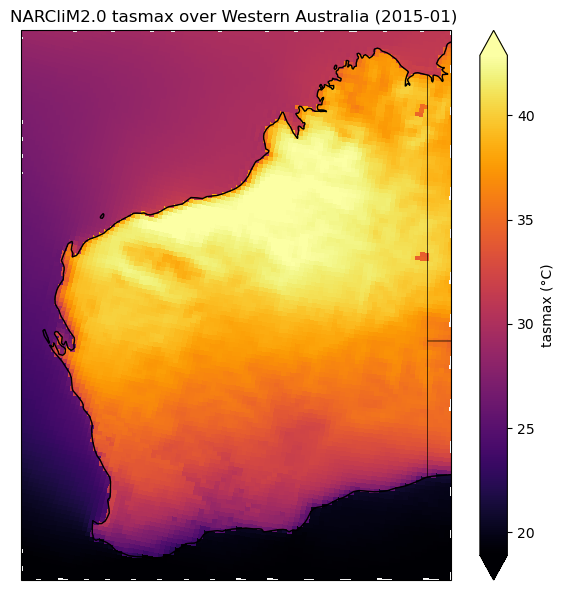

In [5]:
# Select first timestep (January 2015)
t_index = 0

tasmax_wa_single = tasmax_wa.isel(time=t_index)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Zoom to WA region
ax.set_extent([wa_lon_min, wa_lon_max, wa_lat_min, wa_lat_max],
              crs=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.3)

# Plot tasmax using 2-D lat/lon
im = tasmax_wa_single.plot(
    ax=ax,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cmap="inferno",
    robust=True,
    cbar_kwargs={"label": "tasmax (°C)"}
)

time_str = str(tasmax_wa_single["time"].dt.strftime("%Y-%m").values)
ax.set_title(f"NARCliM2.0 tasmax over Western Australia ({time_str}) ")

plt.tight_layout()

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Multiple timesteps 

Multiple-timesteps-faceted:
**2×3 grid of maps**: Jan-Jun 2015 temperature evolution over WA.

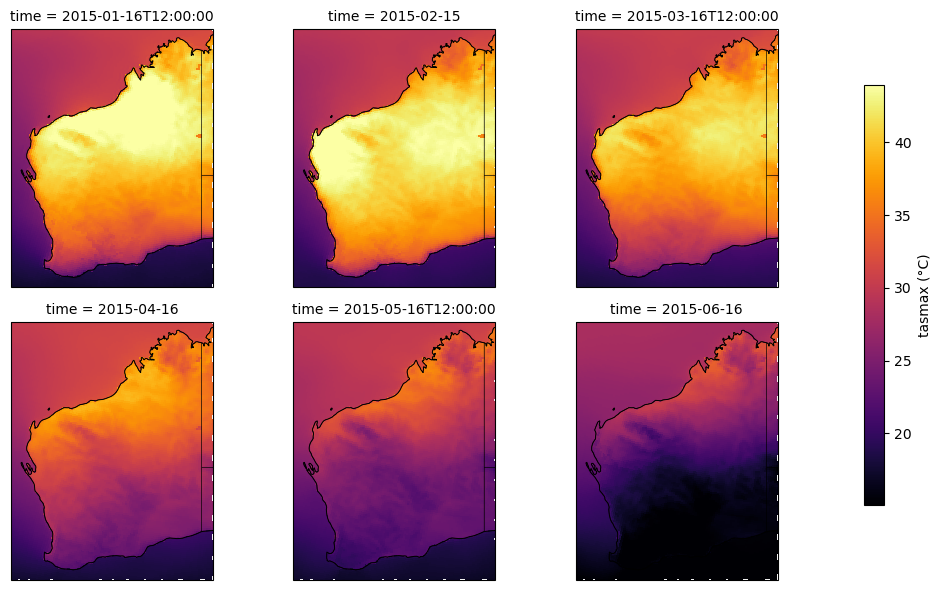

In [6]:
# Select first six months of 2015
tasmax_wa_6 = tasmax_wa.isel(time=slice(0, 6))
g = tasmax_wa_6.plot(
    col="time",
    col_wrap=3,
    x="lon",
    y="lat",
    cmap="inferno",
    robust=True,
    subplot_kws={"projection": ccrs.PlateCarree()},
    add_colorbar=False   # 👈 turn off auto colorbar
)

# --- add one shared colorbar on the side ---
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = g.fig
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

sm = ScalarMappable(cmap="inferno")
sm.set_array(tasmax_wa_6.values)

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("tasmax (°C)")

# --- map features ---
for ax in g.axes.flat:
    if ax is None:
        continue
    ax.set_extent([wa_lon_min, wa_lon_max, wa_lat_min, wa_lat_max],
                  crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m", linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.3)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## July 2015 WA temperature map


This figure shows the spatial pattern of daily maximum temperature (tasmax)
over Western Australia for a representative mid-year month (July 2015).

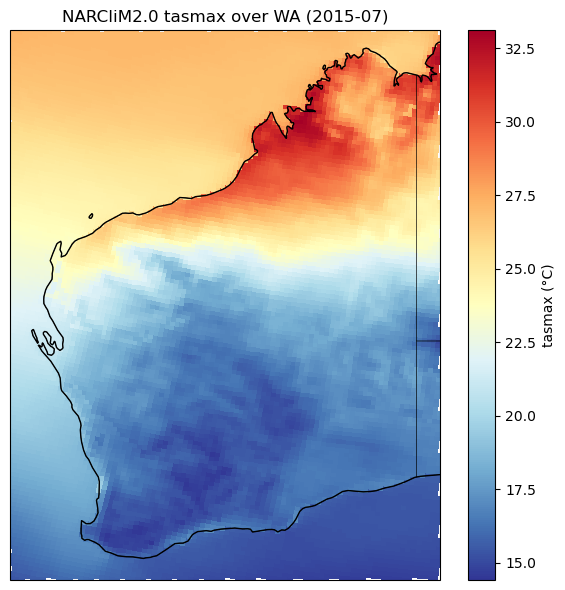

In [7]:
# Choose a mid-year month, e.g. July 2015
t_index = 6
tasmax_wa_july = tasmax_wa.isel(time=t_index)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(
    [wa_lon_min, wa_lon_max, wa_lat_min, wa_lat_max],
    crs=ccrs.PlateCarree()
)

ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.3)

tasmax_wa_july.plot(
    ax=ax,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cmap="RdYlBu_r",
    cbar_kwargs={"label": "tasmax (°C)"}
)

time_str = str(tasmax_wa_july["time"].dt.strftime("%Y-%m").values)
ax.set_title(
    f"NARCliM2.0 tasmax over WA ({time_str})"
)

plt.tight_layout()
plt.show()

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Time series at a single WA location
**12-month temperature time series** from nearest grid point to Perth.

Nearest grid point: rlat=98, rlon=84
lat=-32.022350084853606, lon=115.95722673838013


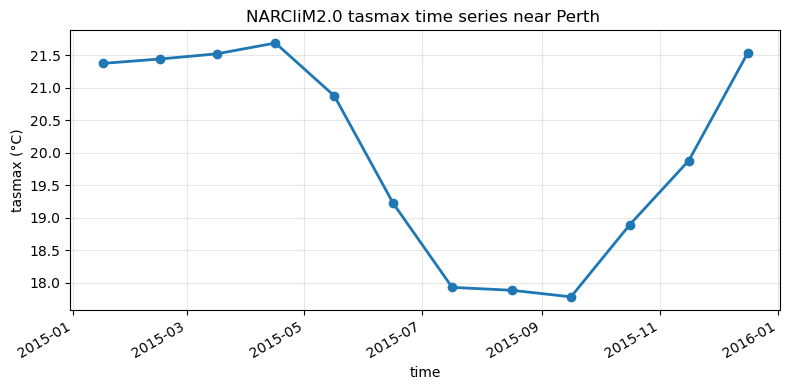

In [8]:
# Pick a location near Perth
target_lon = 116.0
target_lat = -32.0

# Find nearest grid indices using rlat/rlon (the actual dimensions)
# Average lat across rlon to get lat profile of each rlat
lat_profile = ds.lat.mean(dim='rlon')
rlat_idx = (abs(lat_profile - target_lat)).argmin(dim='rlat')

# Average lon across rlat to get lon profile of each rlon  
lon_profile = ds.lon.mean(dim='rlat')
rlon_idx = (abs(lon_profile - target_lon)).argmin(dim='rlon')

print(f"Nearest grid point: rlat={rlat_idx.values}, rlon={rlon_idx.values}")
print(f"lat={float(lat_profile.isel(rlat=rlat_idx))}, lon={float(lon_profile.isel(rlon=rlon_idx))}")

# Extract time series from WA subset using these indices
tasmax_point_wa = tasmax_wa.isel(rlat=rlat_idx, rlon=rlon_idx).squeeze()

# Plot the time series
ts = tasmax_point_wa.to_series().dropna()
plt.figure(figsize=(8, 4))
ts.plot(marker="o", linewidth=2, markersize=6)
plt.ylabel("tasmax (°C)")
plt.title("NARCliM2.0 tasmax time series near Perth ")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
print(ds.lon.min().item(), ds.lon.max().item())
print(ds.lat.min().item(), ds.lat.max().item())

-179.99978637695312 179.99977111816406
-52.57440185546875 12.093093872070312


<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>

## Next steps

- Change WA bounding box (Kimberley, Pilbara focus)
- Plot other variables (`tasmin`, `pr` precipitation)
- Compare scenarios (ssp126 vs ssp370)
- Seasonal/annual averages: `groupby("time.season")`

<div style="text-align: right">
  <a href="#top">Go back to top</a>
</div>